Import libraries

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn

## Data preprocessing step

Load IMDB data

In [2]:
imbd_data = pd.read_csv("/home/fbach/Database/IMDB/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

Make list containing all documents

In [3]:
sentiments = []
docs_list = []
for comment, sentiment in zip(imbd_data.review, imbd_data.sentiment):
    sentences = [sent.lower() for sent in comment]
    docs_list.append(sentences)
    sentiments.append(sentiment)

Create list with all usefeull letters in text

In [4]:
max_len = 1024
letter_set = list(set(np.concatenate(docs_list)))
char_indices = dict((c, i) for i, c in enumerate(letter_set))
indices_char = dict((i, c) for i, c in enumerate(letter_set))

Prepare dataset for LSTM Network

In [5]:
def batch_iter(docs_list, sentiments, batch_len):
    counter = 0
    max_len = 1024
    while True:
        # Initialize variables
        x = np.zeros((batch_len, max_len, len(letter_set)), dtype=np.float32)
        y = np.zeros((batch_len, 1), dtype=np.float32)
        
        # Collect batch
        for b_idx in range(0, batch_len):
            if counter >= len(docs_list):
                counter = 0
            sentence = docs_list[counter]
            for j, doc_letter in enumerate(sentence):
                if j >= max_len:
                    break
                x[b_idx, j, char_indices[doc_letter]] = 1.
            y[b_idx] = sentiments[counter]
            counter += 1
        yield x, y

Show encoded sentence

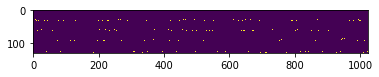

In [6]:
plt.imshow(next(batch_iter(docs_list, sentiments, 105), None)[0][0].transpose())
plt.show()

## RNN Network

In [7]:
def RNN(x, weights, biases, timesteps):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights) + biases


num_classes = 1
timesteps = 28
num_hidden = 128 
# Define weights
weights = tf.Variable(tf.random_normal([num_hidden, num_classes]))
biases = tf.Variable(tf.random_normal([num_classes]))

In [8]:
x = tf.placeholder("float", [None, max_len, len(letter_set)])
y = tf.placeholder("float", [None, num_classes])
logits = RNN(x, weights, biases, max_len)
prediction = tf.nn.sigmoid(logits)

Define crossentropy function

In [9]:
cross_entropy_array = tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=y)
cross_entropy = tf.reduce_mean(cross_entropy_array)

In [10]:
prediction_cast = tf.cast(tf.greater(prediction, 0.5), tf.float32)
is_correct = tf.equal(prediction_cast, y)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [11]:
optimizer = tf.train.RMSPropOptimizer(1e-4)
train_step = optimizer.minimize(cross_entropy)

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [13]:
divide_point = int(0.2 * len(docs_list))
train_docs_list = docs_list[divide_point:]
test_docs_list = docs_list[:divide_point]
train_batch_iter = batch_iter(train_docs_list, sentiments, 128)
test_batch_iter = batch_iter(test_docs_list, sentiments, 128)

In [14]:
test_accuracy = []
test_cross = []
for i in range(2000):
    # Load batch
    batch_X, batch_Y = next(train_batch_iter, None)
    train_data = {x: batch_X, y: batch_Y}

    # Train
    sess.run(train_step, feed_dict=train_data)
    a_train, c_train = sess.run([accuracy, cross_entropy], feed_dict=train_data)

    test_batch_x, test_batch_y = next(test_batch_iter, None)
    test_data = {x: test_batch_x, y: test_batch_y}
    a_test, c_test = sess.run([accuracy, cross_entropy], feed_dict=test_data)
    print("Accuracy: {} (train); {} (test), Cross Entropy: {}; {}".format(a_train, a_test, c_train, c_test))
    
    # Append to list
    test_accuracy.append(a_test)
    test_cross.append(c_test)

Accuracy: 0.4453125 (train); 0.4453125 (test), Cross Entropy: 0.805287003517; 0.806956648827
Accuracy: 0.46875 (train); 0.46875 (test), Cross Entropy: 0.786962509155; 0.7872787714
Accuracy: 0.453125 (train); 0.453125 (test), Cross Entropy: 0.799682617188; 0.798949539661
Accuracy: 0.5 (train); 0.5 (test), Cross Entropy: 0.762882709503; 0.761947214603
Accuracy: 0.53125 (train); 0.53125 (test), Cross Entropy: 0.738685190678; 0.73952627182
Accuracy: 0.484375 (train); 0.484375 (test), Cross Entropy: 0.777346491814; 0.776551246643
Accuracy: 0.4921875 (train); 0.4921875 (test), Cross Entropy: 0.767173409462; 0.770222485065
Accuracy: 0.484375 (train); 0.484375 (test), Cross Entropy: 0.775754928589; 0.774747431278
Accuracy: 0.453125 (train); 0.453125 (test), Cross Entropy: 0.799795627594; 0.799220323563
Accuracy: 0.5625 (train); 0.5625 (test), Cross Entropy: 0.715775966644; 0.716607272625
Accuracy: 0.6015625 (train); 0.6015625 (test), Cross Entropy: 0.685821771622; 0.687432169914
Accuracy: 0.51

KeyboardInterrupt: 